## Table of Contents

* train / test の統計量を確認しよう!
* Simpleなモデルを作ってsubmitしてみよう!

In [47]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用

sns.set_style('darkgrid')

In [48]:
INPUT_DIR = '/analysis/data/atmaCup7/inputs/'
OUTPUT_DIR = '/analysis/data/atmaCup7/outputs/'

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [49]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

In [4]:
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [22]:
train_df.dtypes

request_id                  object
imp_at                      object
target                       int64
adnw_id                      int64
adspot_id                    int64
adspot_video_format_id     float64
advertiser_id               object
app_id                      object
auction_type_id            float64
campaign_id                 object
category_id                  int64
click_or_view_at            object
country_code                object
cv_at                       object
first_login_interval       float64
frequency                    int64
from_click                   int64
game_feed_asset_type_id      int64
game_feed_id                object
game_template_id            object
header_bidding             float64
is_interstitial            float64
item_id                    float64
last_cv_interval           float64
last_login_interval        float64
last_paid_interval         float64
login_frequency            float64
max_login_interval         float64
media_app_id        

In [21]:
train_df.head().T

,0,1,2,3,4
request_id,ad6a7b7894f142d81a1e,ac8453e4a93391812b78,4959adca0d9284e642c9,622c44ebc7cf591d046e,3093c6746ae6e35b9ad5
imp_at,2020-04-28 00:04:14.639000,2020-04-28 00:09:13.759000,2020-04-28 00:09:14.708000,2020-04-28 00:10:40.291000,2020-04-28 00:11:45.895000
target,0,0,0,0,0
adnw_id,4,28,42,8,22
adspot_id,1111,1081,1123,1113,1061
adspot_video_format_id,2,2,3,2,NaN
advertiser_id,1b29c3959fc76425d130,ba2bb260d8eccd0057a4,0aaa2635cef6c96c7932,1ed4e5bb950da757976a,d352ebd3462849796754
app_id,efef8f05c293786ae95d,85518c203c727a6fcd6e,d01b84105c697315f36d,c72faf7a97213d7e4c8c,0376415068bf3e5b9e95
auction_type_id,1,2,1,1,4
campaign_id,9ce932d55f27ed28f0e5,23f7cf2bddc97c599ac4,2dde952bf6521fac0b71,1cbbcb2f33a045e5a09c,84095859da9cffce1c60


## Profile Report を作る

pandas profiling というライブラリがあり、こちらを使うとデータフレームの統計量を一気に確認することが可能です。簡単な使い方は `ProfileReport` class に可視化したいデータフレームを渡して repot を作り `to_file` を呼び出して html ファイルとして保存する方法です。

保存した html をブラウザなどで開くと以下のような統計量をカラムごとに確認できてとても便利です。

* ユニークな値の数
* 頻度の高い値
* 意味の無いカラムや Null が多いカラムかどうか ...etc

In [5]:
report = ProfileReport(train_df)
# report.to_file(os.path.join(OUTPUT_DIR, 'train_report.html'))

## モデリング

### 連続変数の特徴量

連続変数の場合そのままモデルが解釈出来るためコピーすればOKです。通常欠損値があると欠損のことを考慮する必要があります(モデルによっては欠損値が扱えない場合があるからです)。その場合平均値や中央値、更には別の方法で欠損を埋める必要がありますが lightGBM などの GBDT は欠損をそのまま自然に扱えるため、基本的に気にする必要はありません。

In [23]:
def create_continuous_features(input_df):
    use_columns = [
        # 連続変数
        'max_login_interval', 
        'frequency', 
        'login_frequency', 
        'last_login_interval',
        'from_click',
    ]
    return input_df[use_columns].copy()

In [54]:
# assert create_continuous_features(train_df).equals(create_continuous_features(train_df))

### Category系の特徴量

カテゴリ系の特徴量は何らかの方法で数値化必要が必要です。今回は単純にそのまま使えるものを使います

> これは所謂 Label Encoding という方法に相当します (参考: http://nami3373.hatenablog.com/entry/2018/07/26/230655)

In [55]:
def create_category_features(input_df):
    use_columns = [
        # category 系の id. label-encoding として使う
        'adnw_id',
        'adspot_id',
        'adspot_video_format_id',
        'game_feed_asset_type_id'
    ]
    return input_df[use_columns].copy()

In [56]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [57]:
from tqdm import tqdm

def to_feature(input_df):
    processors = [
        create_continuous_features,
        create_category_features
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with timer(prefix='create ' + func.__name__ + ' '):
            _df = func(input_df)
        
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [58]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 2/2 [00:00<00:00, 46.88it/s]

create create_continuous_features 0.065[s]
create create_category_features 0.028[s]
create create_continuous_features 0.017[s]
create create_category_features 0.007[s]


In [62]:
assert len(test_feat_df) == len(test_df)

## LightGBM による学習

特徴量を作成できたので、次に LightGBM による学習を行っていきます。この時大事になるのが交差検証 (Cross Validation) という考え方です。

### Cross Validation

Cross Validation とは学習用のデータセットを複数に分割してそれぞれの分割で学習・検証のデータセットを作り、モデルの性能を見積もる枠組みのことです。

今回この notebook では Cross Validation の一種である Stratified K Fold という分割方法でモデルを5個作ります。
(stratified とは target の positive 割合を各々の分割で同じにするようなわけかたです。)

なぜわざわざ分割するの? (そのまま全部学習で使っちゃえばいいじゃない?) と思われるのが普通だと思います。なぜ分割するかというと学習データの中で今の枠組みの性能(枠組みと言っているのは特徴量・モデルの構成もろもろ全部が含まれるためです)を評価したいからです。手元で評価ができないとLBに出してみて一喜一憂するしかなくなり、結果publicLBにオーバーフィットしてしまうのでよろしくないです。

> 仕事的な観点で言ってもLBに出すというのはデプロイ(本番へ反映すること)ですから、本番に出さないとモデルの良し悪しがわからないのはよろしくないですよね?

一番ナイーブな戦略は `KFold` と呼ばれるものです。これは何も考えずにとにかくランダムに学習データを分割します。

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0041.png)

その他にターゲットの分布が同じになるように分割する Stratified と呼ばれる方法もあります。(今回行なうのはこの方法です)

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0071.png)

あとは「各分割で特定のグループが重ならないようにする」Group K Fold もよく使われます。(よく見ると 0 ~ 4 で group の行の色が被らないようになっているのわかりますか?)

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_0051.png)

その他にも時系列で区切る time split という方法もあります。どれを使えばよいかは test データがどのように構成されているか依存なので、つどつどデータを見て決定します。


In [39]:
from sklearn.metrics import average_precision_score
import lightgbm as lgbm

def pr_auc(y_true, y_pred):
    """lightGBM の round ごとに PR-AUC を計算する用"""
    score = average_precision_score(y_true, y_pred)
    return "pr_auc", score, True

def fit_lgbm(X, y, cv, params: dict=None, verbose=100):

    # パラメータがないときはからの dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMClassifier(**params)
        
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose, 
                    eval_metric=pr_auc,
                    verbose=verbose)

        pred_i = clf.predict_proba(x_valid)[:, 1]
        oof_pred[idx_valid] = pred_i
        models.append(clf)

        print(f'Fold {i} PR-AUC: {average_precision_score(y_valid, pred_i):.4f}')

    score = average_precision_score(y, oof_pred)
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models

### parameter について

基本的にそんなに気にしなくても良いですが max_depth など学習に大きく影響するパラメータもありますのでそこだけ注意してください。

#### 参考

* [勾配ブースティングで大事なパラメータの気持ち](https://nykergoto.hatenablog.jp/entry/2019/03/29/%E5%8B%BE%E9%85%8D%E3%83%96%E3%83%BC%E3%82%B9%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%81%A7%E5%A4%A7%E4%BA%8B%E3%81%AA%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%81%AE%E6%B0%97%E6%8C%81%E3%81%A1): 僕の書いた記事。
* [Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html): lightGBM 公式のパラメータチューニングガイド

In [63]:
params = {
    'objective': 'binary',
    'learning_rate': .1,
    'max_depth': 6,
    'n_estimators': 10000,
    'colsample_bytree': .7
}

y = train_df['target'].values

In [42]:
from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

In [43]:
oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.135757	valid_0's pr_auc: 0.0802203
[200]	valid_0's binary_logloss: 0.135452	valid_0's pr_auc: 0.081391
[300]	valid_0's binary_logloss: 0.135291	valid_0's pr_auc: 0.0822244
[400]	valid_0's binary_logloss: 0.135194	valid_0's pr_auc: 0.0827661
[500]	valid_0's binary_logloss: 0.135144	valid_0's pr_auc: 0.0829716
[600]	valid_0's binary_logloss: 0.135136	valid_0's pr_auc: 0.0830486
Early stopping, best iteration is:
[565]	valid_0's binary_logloss: 0.135132	valid_0's pr_auc: 0.0831288
fit fold=1 111.645[s]
Fold 0 PR-AUC: 0.0831
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.135906	valid_0's pr_auc: 0.0789156
[200]	valid_0's binary_logloss: 0.135626	valid_0's pr_auc: 0.0802717
[300]	valid_0's binary_logloss: 0.135529	valid_0's pr_auc: 0.0809194
[400]	valid_0's binary_logloss: 0.135462	valid_0's pr_auc: 0.0813793
[500]	valid_0's binary_logloss: 0.13546

### 特徴重要度の確認

LightGBM など木系のモデルではどの特徴量で分割を行ってどれだけ目的変数を説明しているかを特徴重要度 (feature importance) として出力することができます。これを見ることで

* どの特徴量が大事なのか
* どの特徴量はあまり大事ではないか

といった特徴量に関する情報を得ることができます。これによって、例えば重要となった特徴量を使う別の特徴を考えたり、反対に大事ではない特徴を削ったりといったインサイトを得ることが可能です。

In [44]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

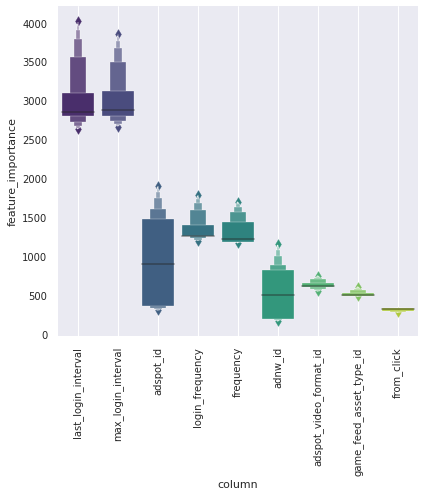

In [45]:
fig, ax = visualize_importance(models, train_feat_df)

In [64]:
pred = np.array([model.predict_proba(test_feat_df.values)[:, 1] for model in models])
pred = np.mean(pred, axis=0)

sub_df = pd.DataFrame({ 'target': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, 'simple_submission.csv'), index=False)

### Future Work

* データをより良く見て、性質を理解する (EDA)
* 特徴量をより凝ったものにする

これらは次回の講座で扱います!